- Cette partie est consacrée au Sentiment analysis des titres d'articles afin de comprendre le ton des articles
- Indentifier les sections relatives au climat
- Une analyse de sentiment sur ces articles :
        - Une première approche par Vader

#### Import des librairies

In [2]:
import os
os.chdir('..')
os.getcwd()

'/Users/hananemaghlazi/Documents/GitHub/quotaclimat'

In [572]:
# Import des librairies
import re,os,glob,time,sys
from pathlib import Path
import pandas as pd 
import numpy as np
import math
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
# Pour les warnings
import warnings
warnings.filterwarnings('ignore')
# Pour le traitement de texte
import nltk
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import (
    sent_tokenize,
    word_tokenize,
    wordpunct_tokenize,
)
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from quotaclimat.data_ingestion.config_sitmap import MEDIA_CONFIG, SITEMAP_CONFIG
from quotaclimat.data_processing.sitemap.sitemap_processing import load_webpress
from quotaclimat.utils import functions

In [566]:
#Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le 
#plus d'informations
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format',lambda x: "%.4f" % x)

In [573]:
# Load sitemap data
df = load_webpress()

- Exploration des données : 

In [13]:
df.head()

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,news_keywords,image,image_loc,image_caption,sitemap,etag,sitemap_last_modified,sitemap_size_mb,download_date,media,section,changefreq,news_access,image_title,lastmod,news_genres,priority,download_date_last,media_type
105623,https://www.lamarseillaise.fr/politique/aix-en-provence-cinq-verites-politiques-de-sophie-joissains-pour-debuter-2023-JH13050595,,,Journal La Marseillaise,fr,2023-01-17 11:55:24,Aix-en-Provence : cinq vérités politiques de Sophie Joissains pour débuter 2023,None,,https://www.lamarseillaise.fr/binrepository/img-0920-2_542-6641535_20230117090309.jpg,"Sophie Joissains n’a pas la faconde de sa mère Maryse Joissains (maire de 2001 à 2021). Mais elle a le goût du contact, et renoue avec les rendez-vous de communication politiques. PHOTO J.N.",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[politique],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105624,https://www.lamarseillaise.fr/societe/une-expropriation-irreguliere-coute-579-millions-d-euros-a-gemenos-EH13050567,,,Journal La Marseillaise,fr,2023-01-17 11:20:49,"Une expropriation irrégulière coûte 5,79&nbsp;millions d’euros à Gémenos",None,,https://www.lamarseillaise.fr/binrepository/2023-01-16_542-6641524_20230117090224.jpg,"Les 57&nbsp;965 m2 de terrains expropriés pour 298&nbsp;000 euros en 1991 ont pris une valeur considérable : 5,79 millions d’euros au jour du jugement de 2013, sans compter les intérêts. photo dr",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105625,https://www.lamarseillaise.fr/societe/gard-les-urgences-sont-saturees-et-tirent-la-sonnette-d-alarme-EH13052204,,,Journal La Marseillaise,fr,2023-01-17 15:50:36,Gard : les urgences sont saturées et tirent la sonnette d’alarme,None,,https://www.lamarseillaise.fr/binrepository/1_542-6591522_20230117154424.jpg,Les services d’urgences gardois ne tiennent qu’à un fil depuis plusieurs semaines. PHOTO AFP,https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,None,None,None,None,NaN,2023-01-19 01:41:00,webpress
105626,https://www.lamarseillaise.fr/politique/la-seyne-sur-mer-le-budget-2023-en-ligne-de-mire-du-conseil-municipal-AH13054325,,,Journal La Marseillaise,fr,2023-01-17 19:40:22,La Seyne-sur-Mer: le budget 2023 en ligne de mire du conseil municipal,None,,https://www.lamarseillaise.fr/binrepository/20230117_542-6651152_20230117193459.jpg,Ambiance studieuse ce mardi lors du premier conseil municipal de l’année. <br />Photo Cesar Mazouzi,https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[politique],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105627,https://www.lamarseillaise.fr/societe/fin-de-la-selection-a-paul-valery-BH13051176,,,Journal La Marseillaise,fr,2023-01-17 12:37:07,Fin de la sélection à Paul Valéry ?,None,,https://www.lamarseillaise.fr/binrepository/img_542-6634578_20230117121312.jpg,"Le SCUM, ici en action, a fait voter la fin de la sélection à l’université Paul Valéry de Montpellier. PHOTO SCUM",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,None,None,None,None,NaN,2023-01-21 01:30:30,webpress


In [15]:
df.sample(100)

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,news_keywords,image,image_loc,image_caption,sitemap,etag,sitemap_last_modified,sitemap_size_mb,download_date,media,section,changefreq,news_access,image_title,lastmod,news_genres,priority,download_date_last,media_type
1505,https://www.ladepeche.fr/2023/03/24/aerospace-valley-veut-accelerer-sur-linnovation-pour-reussir-la-transformation-de-la-filiere-aerospatiale-11080733.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.ladepeche.fr/api/v1/images/view/641b2ac15828570c820205b5/hd/image.jpg,NaN,https://www.ladepeche.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.6779,2023-03-28 02:26:50,ladepeche,unknown,daily,NaN,NaN,2023-03-24 15:30:54,NaN,1.0000,NaT,webpress
251,https://www.midilibre.fr/2023/03/23/un-engagement-durable-pour-lentreprise-vertdallet-11081488.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.midilibre.fr/api/v1/images/view/641bd0ea52115f579203ee00/hd/image.jpg,NaN,https://www.midilibre.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.8305,2023-03-24 02:24:30,midilibre,unknown,daily,NaN,NaN,2023-03-23 04:06:29,NaN,1.0000,NaT,webpress
29,https://www.letelegramme.fr/finistere/lanneuffret/a-lanneuffret-de-la-concentration-a-la-franche-rigolade-a-la-soiree-jeux-de-societe-18-03-2023-13299404.php,,,Le Télégramme,fr,2023-03-18 17:40:00,"À Lanneuffret, de la concentration à la franche rigolade à la soirée jeux de société","Jeux de société,Comité des fêtes de Lanneuffret,Lanneuf’fêtes",,https://www.letelegramme.fr/images/2023/03/18/le-choix-et-l-interet-des-jeux-sont-indeniables-avec-le_7354123.jpg,NaN,https://www.letelegramme.fr/sitemap_news1.xml,"""9c4b1-5f73e640ba3f3""",2023-03-19 10:37:02+00:00,0.6105,2023-03-19 10:37:40,letelegramme,"[finistere, lanneuffret]",NaN,NaN,Le choix et l’intérêt des jeux sont indéniables avec le comité des fêtes Lanneuf’fête.,NaN,NaN,NaN,NaT,webpress
102565,https://www.letelegramme.fr/finistere/saint-pol-de-leon/a-saint-pol-de-leon-les-lyceennes-du-kreisker-en-route-pour-le-national-de-hand-03-02-2023-13271885.php,,,Le Télégramme,fr,2023-02-03 11:33:00,"À Saint-Pol-de-Léon, les lycéennes du Kreisker en route pour le National de hand","sport Ugsel,lycée du Kreisker,Régional Ugsel de handball,National Ugsel de handball",,https://www.letelegramme.fr/images/2023/02/03/les-lyceennes-du-kreisker-iront-a-valence-pour-le_7245520.jpg,None,https://www.letelegramme.fr/sitemap_news.xml,"""dab0a-5f3d5bc9d34c0""",2023-02-04 01:30:01+00:00,0.8543,2023-02-04 01:30:14,letelegramme,"[finistere, saint-pol-de-leon]",None,None,Les lycéennes du Kreisker iront à Valence pour le championnat de France,None,None,NaN,2023-02-04 01:30:14,webpress
88,https://www.midilibre.fr/2023/02/12/epilepsie-il-y-a-plein-de-maladies-differentes-assure-le-dr-pierre-meyer-neuropediatre-au-chu-de-montpellier-10970452.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.midilibre.fr/api/v1/images/view/63e11f1e89a81a3d4453fc7b/hd/image.jpg,NaN,https://www.midilibre.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.8225,2023-02-13 01:45:14,midilibre,unknown,daily,NaN,NaN,2023-02-12 08:01:03,NaN,1.0000,NaT,webpress
106932,https://www.lopinion.fr/international/la-chine-continue-lentement-mais-surement-de-labourer-le-sillon-du-yuan-numerique,,,l'Opinion,fr,2023-01-12 06:06:51,Yuan numérique: la Chine continue de labourer le sillon,"Chine-Economie, yuan, monnaie, dollar",,https://beymedias.brightspotcdn.com/1b/d1/8b52451140ca8c6655072b4a6720/e-cny-sipa.jpg,e-cny.,https://www.lopinion.fr/news-sitemap-latest.xml,None,NaT,0.5541,2023-01-17 01:30:24,lopinion,[international],None,None,e-cny 12/01/2023 Leblanc,2023-01-12 11:06:51,None,NaN,2023-02-04 01:29:59,webpress
2909,https://www.ladepeche.fr/2023/01/31/purple-campus-leader-en-occitanie-10964324.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.ladepeche.fr/api/v1/images/view/63d920741352322ceb42e907/hd/image.jpg,NaN,https://www.ladepeche.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.6856,2023-02-12 01:43:33,ladepeche,unknown,daily,NaN,NaN,2023

- Le but est extraire les sections que nous utiiserons plus tard pour la définition des articles liés au climat
- Les sections sont sous forme de liste et sur la plupart d'eux on trouve plusieurs niveaux: [economie, social],[weekend, business-story],[sports, football, equipe-de-france],[sport, article],[environnement, climat],[industrie-services, tourisme-transport], [finistere, plouigneau], [sport, football]
- Nous pouvons pour réduire le nombre de sections se contenter du premier niveau : [sports, football, equipe-de-france] --> sports, [sport, football]--> sport

- Nettoyage des données : 

- Extraction de la section: cette colonne est sous forme de liste

- Colonnes inutiles

- Concaténation titre et texte d'image

In [574]:
df.sample(10)

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,news_keywords,image,image_loc,image_caption,sitemap,etag,sitemap_last_modified,sitemap_size_mb,download_date,media,section,changefreq,news_access,image_title,lastmod,news_genres,priority,download_date_last,media_type
56,https://www.lesechos.fr/politique-societe/politique/reforme-des-retraites-la-bataille-au-parlement/reforme-des-retraites-la-bataille-au-parlement-1900714,,,Les Échos,fr,2023-02-14 17:08:35,Réforme des retraites : la bataille au Parlement,NaN,,https://media.lesechos.com/api/v1/images/view/63d245378e0bf9057b5c6a96/1280x720/dossier-an-sipa.jpg,NaN,https://www.lesechos.fr/sitemap_news.xml,"W/""56ad4-5f4af31072f61""",2023-02-14 20:56:02+00:00,0.3386,2023-02-15 01:44:07,lesechos,"[politique-societe, politique, reforme-des-retraites-la-bataille-au-parlement]",NaN,NaN,None,NaN,NaN,NaN,NaT,webpress
98,https://www.centrepresseaveyron.fr/2023/02/16/des-podiums-au-cross-country-departemental-pour-le-lpa-11004259.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.centrepresseaveyron.fr/api/v1/images/view/63ee7977157e3c483d463f89/hd/image.jpg,NaN,https://www.centrepresseaveyron.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.9732,2023-02-18 01:41:42,centrepresseaveyron,unknown,daily,NaN,NaN,2023-02-16 17:43:18,NaN,1.0000,NaT,webpress
1265,https://www.letelegramme.fr/morbihan/ploermel/stations-essence-a-ploermel-les-meilleurs-prix-pres-de-chez-moi-aujourd-hui-26-01-2022-12911567.php,,,Le Télégramme,fr,2023-03-28 06:54:53,Stations essence à Plormel : les meilleurs prix près de chez moi aujourd'hui,"Carburants,Gazole moins cher,Tarifs,Prix du gazole,Carburant moins cher",,https://www.letelegramme.fr/images/2023/03/28/stations-essence-a-plormel-les-meilleurs-prix-pres-de-chez-m_7391102.jpg,NaN,https://www.letelegramme.fr/sitemap_news1.xml,"""d96dc-5f800c462712d""",2023-03-29 02:31:02+00:00,0.8493,2023-03-29 02:31:39,letelegramme,"[morbihan, ploermel]",NaN,NaN,None,NaN,NaN,NaN,NaT,webpress
809,https://www.letelegramme.fr/finistere/taule/a-taule-les-u13-du-groupement-des-jeunes-de-l-horn-sont-en-phase-honneur-de-la-coupe-futsal-09-02-2023-13275876.php,,,Le Télégramme,fr,2023-02-09 11:49:00,"À Taulé, les U13 du Groupement des Jeunes de l’Horn sont en phase honneur de la coupe Futsal","Groupement des Jeunes de l’Horn,Coupe Futsal",,https://www.letelegramme.fr/images/2023/02/09/les-u13-du-groupement-des-jeunes-de-l-horn-sont-en-phase_7260433.jpg,NaN,https://www.letelegramme.fr/sitemap_news1.xml,"""d52c6-5f46289f2b564""",2023-02-11 01:29:01+00:00,0.8327,2023-02-11 01:29:33,letelegramme,"[finistere, taule]",NaN,NaN,"Les U13 du Groupement des jeunes de l’Horn sont en phase honneur de la coupe Futsal, samedi 11 février, à Taulé.",NaN,NaN,NaN,NaT,webpress
8,https://investir.lesechos.fr/marches-indices/les-points-bourse/le-cac-40-en-hausse-de-1-emmene-par-les-gains-de-plus-de-4-de-legrand-et-credit-agricole-1905212,,,Les Échos Investir,fr,2023-02-09 17:44:21,"Le Cac 40 en hausse de 1%, emmené par les gains de plus de 4% de Legrand et Crédit Agricole",NaN,,https://media.lesechos.com/api/v1/images/view/63e3d06f686a126d82283d11/1280x720/bourse-de-paris-2-getty.jpg,NaN,https://investir.lesechos.fr/sitemap_news.xml,"W/""24709-5f44bddac5cf5""",2023-02-09 22:26:02+00:00,0.1423,2023-02-10 01:46:01,investir.lesechos,[unknown],NaN,NaN,None,NaN,NaN,NaN,NaT,webpress
18,https://www.centrepresseaveyron.fr/2023/04/01/daft-punk-en-aveyron-un-bateau-piege-le-troll-de-burger-king-florilege-des-meilleurs-poissons-davril-11104923.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.centrepresseaveyron.fr/api/v1/images/view/64286a0a774b8f19e02837aa/hd/image.jpg,NaN,https://www.centrepresseaveyron.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.9810,2023-04-02 02:23:59,centrepresseaveyron,unknown,daily,NaN,NaN,2023-04-01 17:52:58,NaN,1.0000,NaT,webpress
253,https://www.centrepresseaveyron.fr/2023/03/19/handball-double-peine-pour-les-rocettes-11073856.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https:/

- Vérification des NAN:

In [22]:
summary(df)

Data shape: (254226, 9)
___________________________
Data types:
object            8
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls
download_date,datetime64[ns],254226,615,0
etag,object,254226,386,0
image_caption,object,254226,53405,0
media,object,254226,18,0
news_publication_date,object,254226,91624,0
news_title,object,254226,90982,0
section,object,254226,351,0
text,object,254226,92261,0
url,object,254226,127447,0


In [24]:
df.groupby(["media","section"]).count()

url  news_publication_date  \
media               section                                                     
20_minutes          20-mint                         23                     23   
                    actu-generale                    6                      6   
                    arts-stars                      28                     28   
                    auto                           244                    244   
                    bordeaux                       148                    148   
                    by-the-web                     108                    108   
                    cinema                         208                    208   
                    culture                        494                    494   
                    diaporama                      370                    370   
                    economie                       516                    516   
                    elections                        1                      1   
                    emploi                          24                     24   
                    faits_divers                  1793                   1793   
                    food                             8                      8   
                    france                          38                     38   
                    gastronomie                     36                     36   
                    guide-achat                    640                    640   
                    high-tech                      264                    264   
                    hightech                         2                      2   
                    horoscope-quotidien            102                    102   
                    horoscope-quotidien-chinois    103                    103   
                    insolite                       193                    193   
                    justice                        920                    920   
                    lille                          130                    130   
                    livres                          91                     91   
                    loisirs                        112                    112   
                    lyon                           124                    124   
                    magazine                         1                      1   
                    marseille                      111                    111   
                    medias                          51                     51   
                    mode                            17                     17   
                    monde                         1792                   1792   
                    montpellier                    109                    109   
                    nantes                         151                    151   
                    nice                           121                    121   
                    noel                            11                     11   
                    paris                          436                    436   
                    people                         698                    698   
                    planete                        624                    624   
                    podcast                         50                     50   
                    politique                      417                    417   
                    publicommunique                  4                      4   
                    rennes                         133                    133   
                    sante                          390                    390   
                    sciences                       148                    148   
                    serie                           60                     60   
                    societe                       1923                   1923   
                    sortir                           1                      1   
 

In [25]:
df.media.value_counts()

ladepeche              60920
letelegramme           43911
midilibre              32468
lefigaro               28636
lindependant           17618
20_minutes             15997
lopinion               10341
lemonde                10120
centrepresseaveyron     6423
lesechos                5804
liberation              5673
le_point                4443
petitbleu               3067
investir.lesechos       2298
lexpress                2202
lequipe                 1665
nouvel_obs              1335
lamarseillaise          1305
Name: media, dtype: int64

In [ ]:
df.section.value_counts()

In [40]:
df["section"].tail(100)

86761                   [sport]
86762     [coupe-du-monde-2022]
86763                   [sport]
86764                   [sport]
86765               [politique]
86766                 [societe]
86767                       [o]
86768              [chroniques]
86769                       [o]
86770               [politique]
86771                       [o]
86772                   [monde]
86720                   [monde]
86721                 [societe]
86722                   [monde]
86723                [economie]
86724    [coronavirus-de-wuhan]
86725                 [societe]
86726                [economie]
86727                 [justice]
86728                [bibliobs]
86729                 [societe]
86730                   [monde]
86731                 [societe]
86732                [economie]
86733                   [monde]
86734                 [musique]
86735                   [monde]
86736                   [monde]
86737               [politique]
86738                 [teleobs]
86739   

- Récupérer les sections : 

In [575]:
sections=(set((itertools.chain(*df.section.values.tolist())))) # Extraire les sections
print("Il y a ",len(sections),"section")

Il y a  1914 section


In [576]:
sections

{'',
 'penurie-de-carburant',
 'coronavirus-de-wuhan',
 'crozon',
 '2295715',
 'ambon',
 'quessoy',
 'coupe-du-monde-2023',
 'tredrez-locquemeau',
 'saint-philibert',
 'coronavirus',
 '2295607',
 'festival-interceltique-de-lorient-2023',
 'tredion',
 'loperhet',
 'boites-de-nuit-souvenirs-souvenirs-dans-le-pays-de-pontivy',
 'aux-petits-soins-du-centre-bretagne',
 'surf',
 'plouay',
 'un-an-de-guerre-en-ukraine-vu-de-la-bretagne',
 'landerneau-bretagne-basket',
 'guipavas',
 'quemper-guezennec',
 'grand-prix-amerique-mag',
 'kernevel',
 'goulien',
 'loudeac',
 'printemps-2023-les-nouveaux-arbustes-a-fleur',
 'cast',
 'm-styles',
 'guiler-sur-goyen',
 'art-contemporain',
 'hemonstoir',
 'stade-briochin',
 'cross-country',
 'ile-molene',
 'economie',
 'editos-analyses',
 'crehen',
 'trouver-un-dentiste-en-cornouaille-mission-impossible',
 'justice',
 'pencran',
 'gestel',
 'critique-litteraire',
 'le-pont-de-lezardrieux-en-chantier-pendant-deux-ans',
 'archives',
 'guisseny',
 'littoral-

- Liste à chercher : 

In [577]:
climate_sections = [
    "climat",
    "cop",
    "crise-climatique",
    "ecologie",
    "eelv",
    "ecosysteme",
    "empreinte-carbone",
    "energie",
    "energie-environnement",
    "energie-petrole-nucleaire-renouvelables-geopolitique",
    "energies",
    "environnement",
    "environnement-et-sante",
    "europe-ecologie-les-verts",
    "financement-de-travaux-et-renovation-energetique",
    "leolien-au-sein-de-loudeac-communaute",
    "leolien-autour-de-guingamp",
    "nucleaire",
    "nucleaire-iranien",
    "parc-eolien-en-baie-de-saint-brieuc-des-annees-de-tensions",
    "plan-de-sobriete",
    "planete",
    "planete-locale",
    "pollution-air",
    "renovation-travaux",
    "sur-le-green",
    "gaz-de-schiste",
    "biodiversite",
    "essence"
    
]

checker et compter le nombre de fois où on trouve ces mots

In [578]:
msk = df['section'].apply(lambda x: not set(x).isdisjoint(climate_sections))

df_climat = df[msk][["news_title", "section","media","image_caption"]]

In [579]:
df_climat.shape

(2288, 4)

In [551]:
df_climat

,news_title,section,media,image_caption
27,Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM."
91,Atmosud célèbre 50 ans d’engagement pour un air respirable,[environnement],lamarseillaise,Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR
97,Contre le transfert des émissions polluantes de l’air vers la mer,[environnement],lamarseillaise,"Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T."
100,Nouveau rebondissement pour la carrière de Borie,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM."
120,Une nouvelle ferme urbaine pour engranger du local,[environnement],lamarseillaise,"Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C."
...,...,...,...,...
427722,"Brésil : la déforestation de l’Amazonie a reculé sur un an, mais est en forte hausse depuis l’arrivée au pouvoir de Jair Bolsonaro, président sortant",[ecologie],nouvel_obs,"Dans l’ensemble, la déforestation de l’Amazonie au Brésil elle est en forte hausse depuis l’arrivée au pouvoir du président sortant Jair Bolsonaro."
427807,Letzte Generation s’introduit sur les pistes des aéroports de Berlin et Munich,[ecologie],nouvel_obs,"Des photos prises et publiées par le collectif Letzte Generation, ce jeudi."
427823,"Des millions de poussins mâles continueront d’être éliminés, malgré la promesse du gouvernement",[ecologie],nouvel_obs,10% des poussins mâles continueront a être tués par gazage.
427829,Au procès de Total pour ses projets en Ouganda et Tanzanie : « C’est la survie de l’humanité qui est en jeu »,[ecologie],nouvel_obs,Sur le chantier TotalEnergies en Ouganda dans le Parc national des Murchison Falls .


In [552]:
df_climat["section"].tail(1000)

350066                     [planete, article]
350069                     [planete, article]
350080                     [planete, article]
350106                     [planete, article]
350118                     [planete, article]
350132                     [planete, article]
350146                     [planete, article]
350157                     [planete, article]
350205                     [planete, article]
350228                     [planete, article]
350232                     [planete, article]
350256                     [planete, article]
350275                     [planete, article]
350278                     [planete, article]
350285                     [planete, article]
350289                     [planete, article]
350294                     [planete, article]
350362                     [planete, article]
350370                     [planete, article]
350379                     [planete, article]
350399                     [planete, article]
350422                     [planet

Sentiment Analysis :  Vader

Nous utiliserons le lexique vade pour obtenir les scores de sentiment car cela fonctionne sans nécessiter de prétraitement de texte approfondi comme la tokenisation et la lemmatisation/racine.

Le score composé est une métrique qui calcule la somme de toutes les notes du lexique qui ont été normalisées entre -1 (négatif le plus extrême) et +1 (positif le plus extrême).

positive sentiment : (compound score >= 0.05)
neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
negative sentiment : (compound score <= -0.05)

In [590]:
def get_text(x): 
    return str(x).replace('&nbsp', '').replace('«;', '').replace(';»', '').replace('<br />', '').replace(';:', '')

df_climat['news_title'] = df_climat['news_title'].apply(lambda row : get_text(row))

In [591]:
df_climat.tail(100)

,news_title,section,media,image_caption,score,sentiment
75253,Lyon : Des militants s’introduisent sur un site Arkema pour dénoncer la pollution,[planete],20_minutes,Des militants d'Extinction Rébellion ont pénétré samedi sur le site industriel d'Arkema à Pierre-Bénite.,0.0000,Neutre
75255,Afrique du Sud : Une vague scélérate fait trois morts et 17 blessés graves,[planete],20_minutes,Des vagues (illustration).,-0.3818,Negative
75289,Bretagne : Le Finistère en vigilance orange ce dimanche pour pluie-inondation,[planete],20_minutes,Une personne avec un parapluie (illustration).,0.0000,Neutre
89607,"La couche d’ozone se reconstitue : quand on veut, on peut !",[environnement],lexpress,La couche d'ozone se reconstitue mais pourrait être menacée par la géo-ingénierie,0.0000,Neutre
89612,"Prix de l’électricité : le marché et Bruxelles, boucs émissaires parfaits",[environnement],lexpress,"En janvier 2022, le drapeau européen flottait sous l'Arc de Triomphe, à Paris, pour célébrer le début de la présidence française de l'Union européenne.",0.0000,Neutre
89525,"La couche d'ozone ""en bonne voie"" pour se reconstituer : ce que dit le dernier rapport de l'ONU",[environnement],lexpress,"La couche d'ozone pourrait se rétablir dans les quatre décennies à venir, selon des chercheurs de l'ONU.",0.0000,Neutre
89560,Recyclage des emballages plastiques : comment la Lituanie est devenue un champion européen,[environnement],lexpress,"La Lituanie fait figure de modèle, dans l'Union européenne, dans la collecte et le recyclage d'emballages plastiques. (photo d'illustration)",0.5994,Positive
89644,Loi sur les énergies renouvelables : ce que contient le texte adopté par l’Assemblée nationale,[environnement],lexpress,"Panneau photovoltaïque à Chambéry, en juin 2005",0.0000,Neutre
89680,"Loi sur les énergies renouvelables : ""Il y a ceux qui se battent pour le climat, et les autres""",[environnement],lexpress,"Photo de l'Assemblée nationale à Paris, prise le 19 octobre 2022",0.0000,Neutre
89730,"COP28 : ""choquante"" ou ""utile"" ? La nomination du PDG du géant pétrolier des Emirats divise",[environnement],lexpress,"Photo fournie par le ministère émirati des Affaires présidentielles le 28 novembre 2022 du ministre de l'Inductrie et chef de la compagnie pétrolière nationale ADNOC, Sultan Ahmed al-Jaber, désigné le 12 janvier 2023 président de la COP28 prévue aux Emirats",0.0000,Neutre


In [592]:
#import nltk and vader lexicon packages
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


#assign compound scores for each ted talk
df_climat['score'] = df_climat['news_title'].map(lambda x: sid.polarity_scores(x)['compound'])

df_climat.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hananemaghlazi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,news_title,section,media,image_caption,score,sentiment
105842,Carrière Borie : le collectif attaque le projet écocide en justice,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.5267,Positive
105821,Atmosud célèbre 50 ans d’engagement pour un air respirable,[environnement],lamarseillaise,Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,0.0000,Neutre
105827,Contre le transfert des émissions polluantes de l’air vers la mer,[environnement],lamarseillaise,"Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",0.0000,Neutre
105830,Nouveau rebondissement pour la carrière de Borie,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.0000,Neutre
105777,Une nouvelle ferme urbaine pour engranger du local,[environnement],lamarseillaise,"Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",0.0000,Neutre
105886,Lancement de la journée mondiale pour restaurer les zones humides,[environnement],lamarseillaise,"Après la matinée, deux visites aux salins d’Hyères étaient prévues pour constater sur le terrain les restaurations effectuées. Photo C.M.",0.0000,Neutre
105887,La députée Marina Mesure en visite à la carrière Borie,[environnement],lamarseillaise,La députée ne s’interdit pas de porter le dossier au ministère. Photo C.-A.L.,0.0000,Neutre
105596,La ZFE dans les quartiers pauvres en fait une zone à forte exclusion,[environnement],lamarseillaise,"«&nbsp;Les pauvres au garage&nbsp;!&nbsp;», clamaient les militants déguisés <br />en riches sur le marché de la place Cadenat. Photo D.C.",-0.2960,Negative
105612,Aix : le chancre coloré condamne trois platanes,[environnement],lamarseillaise,"Depuis 2016, plus de 30 platanes ont été abattus sur le cours Mirabeau. PHOTO A.M.",0.0000,Neutre
105618,"La vie oasienne, un bijou aussi précieux que fragile",[environnement],lamarseillaise,Les photographies de Francis Tack resteront affichées au centre social Bernard Dubois pendant deux semaines. Photo A.M.,0.0000,Neutre


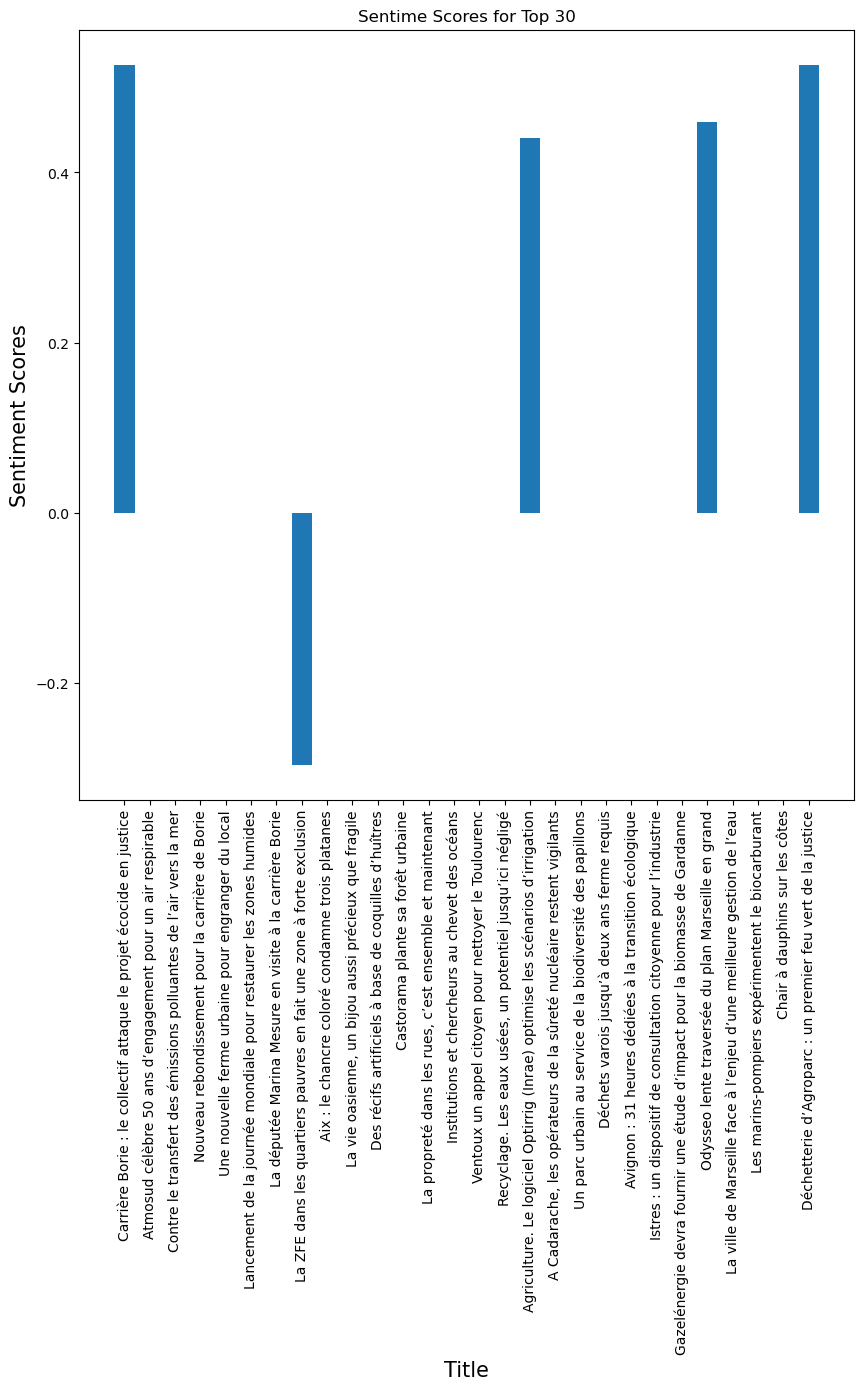

In [593]:
#viz of the polarity scores for top 30 talks
fig = plt.figure(figsize=(10,10))
plt.bar(df_climat.news_title.head(30),df_climat.score.head(30))
plt.xticks(rotation=90)
plt.title('Sentime Scores for Top 30')
plt.xlabel('Title', fontsize=15)
plt.ylabel('Sentiment Scores', fontsize=15)
plt.show()

In [594]:
# Sentiment
def Sentiment(row):
    if row["score"] >= 0.05 :
        sentiment = "Positive"
    elif row["score"] <= -0.05 :
        sentiment = "Negative"
   
    else:
        sentiment = "Neutre"
        
    return sentiment
df_climat['sentiment'] = df_climat.apply(lambda row: Sentiment(row),axis=1)

In [595]:
df_climat

,news_title,section,media,image_caption,score,sentiment
105842,Carrière Borie : le collectif attaque le projet écocide en justice,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.5267,Positive
105821,Atmosud célèbre 50 ans d’engagement pour un air respirable,[environnement],lamarseillaise,Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,0.0000,Neutre
105827,Contre le transfert des émissions polluantes de l’air vers la mer,[environnement],lamarseillaise,"Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",0.0000,Neutre
105830,Nouveau rebondissement pour la carrière de Borie,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.0000,Neutre
105777,Une nouvelle ferme urbaine pour engranger du local,[environnement],lamarseillaise,"Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",0.0000,Neutre
...,...,...,...,...,...,...
86503,"Brésil : la déforestation de l’Amazonie a reculé sur un an, mais est en forte hausse depuis l’arrivée au pouvoir de Jair Bolsonaro, président sortant",[ecologie],nouvel_obs,"Dans l’ensemble, la déforestation de l’Amazonie au Brésil elle est en forte hausse depuis l’arrivée au pouvoir du président sortant Jair Bolsonaro.",0.0000,Neutre
86697,Letzte Generation s’introduit sur les pistes des aéroports de Berlin et Munich,[ecologie],nouvel_obs,"Des photos prises et publiées par le collectif Letzte Generation, ce jeudi.",0.0000,Neutre
86713,"Des millions de poussins mâles continueront d’être éliminés, malgré la promesse du gouvernement",[ecologie],nouvel_obs,10% des poussins mâles continueront a être tués par gazage.,0.0000,Neutre
86719,Au procès de Total pour ses projets en Ouganda et Tanzanie : « C’est la survie de l’humanité qui est en jeu »,[ecologie],nouvel_obs,Sur le chantier TotalEnergies en Ouganda dans le Parc national des Murchison Falls .,0.0000,Neutre


Neutre      1992
Positive     159
Negative     137
Name: sentiment, dtype: int64


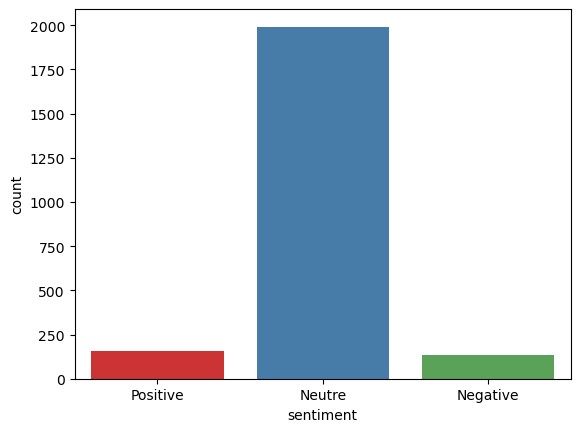

In [596]:
sns.countplot(x="sentiment", data=df_climat, palette="Set1")
print(df_climat.sentiment.value_counts())

Analyse des résultats : 

In [597]:
df_climat.query('sentiment == "Positive" ')

,news_title,section,media,image_caption,score,sentiment
105842,Carrière Borie : le collectif attaque le projet écocide en justice,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.5267,Positive
16,Agriculture. Le logiciel Optirrig (Inrae) optimise les scénarios d’irrigation,[environnement],lamarseillaise,None,0.4404,Positive
20,Odysseo lente traversée du plan Marseille en grand,[environnement],lamarseillaise,"Objets de la convoitise&nbsp;: la gare maritime de la Joliette et, au large, le Frioul. PHOTO LM",0.4588,Positive
16,Odysseo lente traversée du plan Marseille en grand,[environnement],lamarseillaise,"Objets de la convoitise&nbsp;: la gare maritime de la Joliette et, au large, le Frioul. PHOTO LM",0.4588,Positive
24,Déchetterie d’Agroparc : un premier feu vert de la justice,[environnement],lamarseillaise,"En décembre, les riverains s’étaient réunis contre le fauchage <br />du site et s’inquiétaient pour la biodiversité. PHOTO archives F.C.",0.5267,Positive
63,Agriculture. Le logiciel Optirrig (Inrae) optimise les scénarios d’irrigation,[environnement],lamarseillaise,None,0.4404,Positive
25,Déchetterie d’Agroparc : un premier feu vert de la justice,[environnement],lamarseillaise,"En décembre, les riverains s’étaient réunis contre le fauchage <br />du site et s’inquiétaient pour la biodiversité. PHOTO archives F.C.",0.5267,Positive
24,Agriculture. Le logiciel Optirrig (Inrae) optimise les scénarios d’irrigation,[environnement],lamarseillaise,None,0.4404,Positive
32,La Métropole de Toulon passive face aux pics de pollution,[environnement],lamarseillaise,La Métropole a déployé des bus davantage respectueux de l’environnement ces dernières années. PHOTO DR,0.2023,Positive
102949,Top départ pour la relance du nucléaire,"[industrie-services, energie-environnement]",lesechos,None,0.2023,Positive


In [598]:
df_climat.query('sentiment == "Negative" ')

,news_title,section,media,image_caption,score,sentiment
105596,La ZFE dans les quartiers pauvres en fait une zone à forte exclusion,[environnement],lamarseillaise,"«&nbsp;Les pauvres au garage&nbsp;!&nbsp;», clamaient les militants déguisés <br />en riches sur le marché de la place Cadenat. Photo D.C.",-0.2960,Negative
60,Greenwashing : l'Europe siffle la fin de la récréation,"[industrie-services, energie-environnement]",lesechos,NaN,-0.1027,Negative
73,Nucléaire : autopsie d'un fiasco,"[industrie-services, energie-environnement]",lesechos,NaN,-0.5106,Negative
104,Nucléaire : autopsie d'un fiasco,"[industrie-services, energie-environnement]",lesechos,NaN,-0.5106,Negative
172,Greenwashing : l'Europe siffle la fin de la récréation,"[industrie-services, energie-environnement]",lesechos,NaN,-0.1027,Negative
71139,Greenwashing : TotalEnergies visé par une enquête pour «pratiques commerciales trompeuses»,"[environnement, climat]",liberation,"Des manifestants contre un projet de pipeline de TotalEnergies, le 29 septembre 2022 à Kampala, en Ouganda.",-0.1027,Negative
70202,Une vague de froid extrême saisit la Sibérie et sévit jusqu’en Russie occidentale,"[environnement, climat]",liberation,"Malgré des températures atteignant les - 50°C, le fleuve Ienisseï ne gèle pas à Krasnoïarsk, en raison d'un barrage hydroélectrique situé en amont.",-0.1027,Negative
71009,Abandon des néonicotinoïdes par la France : des betteraviers sous le choc après un abus de confiance,"[environnement, biodiversite]",liberation,"Comptant 21 sucreries sur le territoire français, la filière de la betterave représente 45 000 emplois en agriculture et dans l’industrie.",-0.4404,Negative
70726,"Greta Thunberg face à Davos, «l’endroit où sont les gens qui alimentent le plus la destruction de la planète»","[environnement, climat]",liberation,Greta Thunberg en Allemagne le 14 janvier 2023.,-0.5719,Negative
70389,Réchauffement climatique : ExxonMobil avait tout vu... et s’est bien gardé de le dire,"[environnement, climat]",liberation,"A la raffinerie Esso de Notre-Dame-de-Gravenchon (Seine-Maritime), en octobre.",-0.5423,Negative


In [599]:
df_climat.query('sentiment == "Neutre" ')

,news_title,section,media,image_caption,score,sentiment
105821,Atmosud célèbre 50 ans d’engagement pour un air respirable,[environnement],lamarseillaise,Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,0.0000,Neutre
105827,Contre le transfert des émissions polluantes de l’air vers la mer,[environnement],lamarseillaise,"Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",0.0000,Neutre
105830,Nouveau rebondissement pour la carrière de Borie,[environnement],lamarseillaise,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",0.0000,Neutre
105777,Une nouvelle ferme urbaine pour engranger du local,[environnement],lamarseillaise,"Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",0.0000,Neutre
105886,Lancement de la journée mondiale pour restaurer les zones humides,[environnement],lamarseillaise,"Après la matinée, deux visites aux salins d’Hyères étaient prévues pour constater sur le terrain les restaurations effectuées. Photo C.M.",0.0000,Neutre
...,...,...,...,...,...,...
86503,"Brésil : la déforestation de l’Amazonie a reculé sur un an, mais est en forte hausse depuis l’arrivée au pouvoir de Jair Bolsonaro, président sortant",[ecologie],nouvel_obs,"Dans l’ensemble, la déforestation de l’Amazonie au Brésil elle est en forte hausse depuis l’arrivée au pouvoir du président sortant Jair Bolsonaro.",0.0000,Neutre
86697,Letzte Generation s’introduit sur les pistes des aéroports de Berlin et Munich,[ecologie],nouvel_obs,"Des photos prises et publiées par le collectif Letzte Generation, ce jeudi.",0.0000,Neutre
86713,"Des millions de poussins mâles continueront d’être éliminés, malgré la promesse du gouvernement",[ecologie],nouvel_obs,10% des poussins mâles continueront a être tués par gazage.,0.0000,Neutre
86719,Au procès de Total pour ses projets en Ouganda et Tanzanie : « C’est la survie de l’humanité qui est en jeu »,[ecologie],nouvel_obs,Sur le chantier TotalEnergies en Ouganda dans le Parc national des Murchison Falls .,0.0000,Neutre


- Traitement de texte : 

In [114]:
# Stop words
stop_w = list(set(stopwords.words("french"))) + [
    "[",
    "]",
    ",",
    ".",
    ":",
    "?",
    "(",
    ")",
]

In [115]:
# Tokenizer
def tokenizer_fct(sentence):
    # print(sentence)
    sentence_clean = (
        sentence.replace("-", " ").replace("+", " ").replace("/", " ").replace("#", " ")
    )
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens



def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    #filtered_w3 = [w for w in filtered_w2 if not w in list_unique_words]
    return filtered_w2


# lower case et alpha
def lower_start_fct(list_words):
    lw = [
        w.lower().strip()
        for w in list_words
        if (not w.startswith("@"))
        and (not w.startswith("#"))
        and (not w.startswith("http"))
    ]
    return lw


# Lemmatizer (base d'un mot)


def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [116]:
# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = " ".join(lem_w)
    return transf_desc_text

In [117]:
df_climat["sentence_bow_lem"] = df_climat["text"].apply(lambda x: transform_bow_lem_fct(x))

In [118]:
df_climat.head()

,text,media,sentence_bow_lem
0,"Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,carrière borie collectif attaque projet nbsp écocide nbsp justice cette zone naturelle protégée accessible tous riveraine carpiagne parc national calanques départ nombreuses promenade pratiques sportives donne accès gr2013 photo
1,Atmosud célèbre 50 ans d’engagement pour un air respirable Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,lamarseillaise,atmosud célèbre an engagement air respirable près 200 partenaires adhérents atmosud réunis pharo mardi photo
2,"Contre le transfert des émissions polluantes de l’air vers la mer Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",lamarseillaise,contre transfert émissions polluantes air vers mer le militant collectif climat zéro fossile rencontre population inviter conférence nbsp ensemble sauvons méditerranée mort annoncée pollution marine nbsp photo t.t
3,"Nouveau rebondissement pour la carrière de Borie Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,nouveau rebondissement carrière borie cette zone naturelle protégée accessible tous riveraine carpiagne parc national calanques départ nombreuses promenade pratiques sportives donne accès gr2013 photo
4,"Une nouvelle ferme urbaine pour engranger du local Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",lamarseillaise,une nouvelle ferme urbaine engranger local olivier bougé agriculteur président association paysans avignon olivier cadart bénévole terre lien vont garder œil attentif travaux ferme photo f.c
